In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from  tqdm import  tqdm
from scipy.special import binom
import itertools
import helpers as hp
import simulations as sims
import importlib
from scipy.optimize import curve_fit
importlib.reload(sims)

plt.style.use('ggplot')

FIG_PATH = "./../../figures/"

# Load and process data

In [6]:
data= pd.read_csv('./../../experimental_data/processed_data/single_cell_data.csv')
data_avg = pd.read_csv('./../../experimental_data/processed_data/avg_data.csv')
data_avg_one_cell = pd.read_csv('./../../experimental_data/processed_data/avg_data_one_cell.csv')
fits = pd.read_csv('./output/fits_summary.csv')
fits['p'] = fits.beta_population.values/(2*fits.alpha_population.values)
experiments = data.experiment.unique()
experiments
fits

,Unnamed: 0,Unnamed: 0.1,experiment,defect,nuclease,alpha_population,beta_population,p,rho
0,0,0,NR-SpCas9,NR,SpCas9,0.003853,0.001968,0.255443,0.001505
1,1,1,CTG-Cpf1,CTG,Cpf1,0.003870,0.000103,0.013321,0.000344
2,2,2,CGG-Cpf1,CGG,Cpf1,0.003575,0.000011,0.001534,0.000022
3,3,3,NoGuideRNA,none,none,0.004020,NaN,NaN,NaN
4,4,4,GAA-SpCas9-comb,GAA,SpCas9,0.001823,0.000333,0.091273,0.000167
5,5,5,GAA - Cpf1,GAA,Cpf1,0.003784,0.001377,0.182013,0.002260
6,6,6,CTG-SpCas9-comb,CTG,SpCas9,0.002480,0.000913,0.183999,0.000307
7,7,7,CGG-SpCas9,CGG,SpCas9,0.003871,0.002027,0.261829,0.001021
8,8,8,NR-Cpf1-comb,NR,Cpf1,0.004104,0.002268,0.276287,0.001992


In [9]:
data_dsb_raw = pd.read_csv('./../../experimental_data/processed_data/DSB_GFP.txt',delimiter="\t")
data_dsb_raw
times = np.array([0,2,4,6,8,10,12])
defects = np.concatenate([data_dsb_raw.Repeat.values,data_dsb_raw.Repeat.values])
data_dsb1 = data_dsb_raw.drop(labels=["GFP (SpCas9)","DSB (SpCas9)"],axis=1,inplace=False)
data_dsb1 = data_dsb1.rename(columns= {"Repeat":"defect","Time (hr)":"time","GFP (Cpf1)":"gfp","DSB (Cpf1)":"dsb"})
data_dsb1["nuclease"] = ["Cpf1"]*len(data_dsb1)
data_dsb2 = data_dsb_raw.drop(labels=["GFP (Cpf1)","DSB (Cpf1)"],axis=1,inplace=False)
data_dsb2 = data_dsb2.rename(columns= {"Repeat":"defect","Time (hr)":"time","GFP (SpCas9)":"gfp","DSB (SpCas9)":"dsb"})
data_dsb2["nuclease"] = ["SpCas9"]*len(data_dsb2)
data_dsb = pd.concat([data_dsb1,data_dsb2])
data_dsb.to_csv('./../../experimental_data/processed_data/DSB_df.txt')

In [74]:
df

,defect,time,gfp,dsb,nuclease
0,CTG,0,0,0,SpCas9
1,CTG,2,0,2,SpCas9
2,CTG,4,2,3,SpCas9
3,CTG,6,13,3,SpCas9
4,CTG,8,24,2,SpCas9
5,CTG,10,35,2,SpCas9
6,CTG,12,44,3,SpCas9
7,GAA,0,11,3,SpCas9
8,GAA,2,11,5,SpCas9
9,GAA,4,15,7,SpCas9


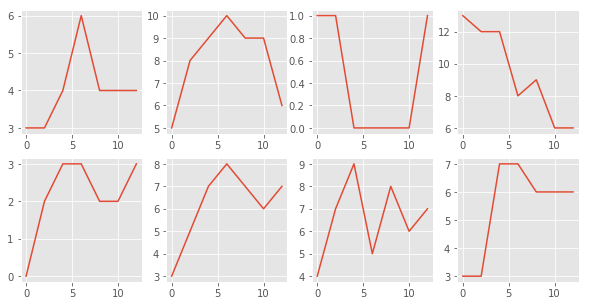

In [97]:
fig,axs = plt.subplots(ncols = 4,nrows=2,figsize=(10,5))
df = data_dsb[data_dsb.nuclease=="Cpf1"]
defects = df.defect.unique()
for k in range(4):
    ax = axs[0,k]
    gfp = df[df.defect==defects[k]].gfp.values
    dsb = df[df.defect==defects[k]].dsb.values
    time = df[df.defect==defects[k]].time.values
    ax.plot(time,dsb)

df = data_dsb[data_dsb.nuclease=="SpCas9"]
defects = df.defect.unique()
for k in range(4):
    ax = axs[1,k]
    gfp = df[df.defect==defects[k]].gfp.values
    dsb = df[df.defect==defects[k]].dsb.values
    ax.plot(times,dsb)

In [64]:
plt.plot(data_dsb[data_dsb.Repeat == "NR"]["Time (hr)"],data_dsb[data_dsb.Repeat == "NR"]["GFP (SpCas9)"],"--")
plt.plot(data_dsb[data_dsb.Repeat == "NR"]["Time (hr)"],data_dsb[data_dsb.Repeat == "NR"]["DSB (SpCas9)"])
#plt.plot(data[data.Repeat == "CTG"]["Time (hr)"],data[data.Repeat == "CTG"]["GFP (SpCas9)"])
#plt.plot(data[data.Repeat == "CTG"]["Time (hr)"],data[data.Repeat == "CAA"]["GFP (Cpf1)"])
#plt.plot(data[data.Repeat == "CTG"]["Time (hr)"],data[data.Repeat == "CGG"]["GFP (SpCas9)"])
ax = plt.gca()
#ax.set_ylim([0,100])

AttributeError: 'DataFrame' object has no attribute 'Repeat'

In [75]:
def fit_func(t,lnalpha,lnbeta,lnrho):
    alpha = np.exp(lnalpha)
    beta = np.exp(lnbeta)
    rho = np.exp(lnrho)
    dsb_n = beta*(alpha+rho)*(np.exp(t*(alpha-beta+rho))-1)
    dsb_d = -alpha*beta + np.exp(t*(alpha-beta+rho))*alpha*(alpha+rho) + np.exp(t*(alpha+rho))*rho*(alpha-beta+rho)
    dsb = dsb_n/dsb_d
    gfp_n = rho*(beta-np.exp(t*(alpha-beta+rho))*(alpha+rho)+np.exp(t*(alpha+rho))*(alpha-beta+rho))
    gfp = gfp_n/dsb_d
    return dsb
    
    
def gfp_func(t,lnalpha,lnbeta,lnrho):
    alpha = np.exp(lnalpha)
    beta = np.exp(lnbeta)
    rho = np.exp(lnrho)
    dsb_n = beta*(alpha+rho)*(np.exp(t*(alpha-beta+rho))-1)
    dsb_d = -alpha*beta + np.exp(t*(alpha-beta+rho))*alpha*(alpha+rho) + np.exp(t*(alpha+rho))*rho*(alpha-beta+rho)
    dsb = dsb_n/dsb_d
    gfp_n = rho*(beta-np.exp(t*(alpha-beta+rho))*(alpha+rho)+np.exp(t*(alpha+rho))*(alpha-beta+rho))
    gfp = gfp_n/dsb_d
    return gfp
    

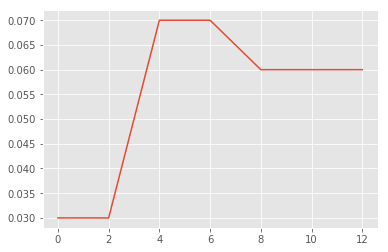

In [94]:
#y_data = np.array([data[data.Repeat == "NR"]["DSB (Cpf1)"],data[data.Repeat == "NR"]["GFP (Cpf1)"]])
df = data_dsb[data_dsb.defect== "NR"]
df = df[df.nuclease == "SpCas9"]
y_data =df.dsb/100
times = df.time
plt.plot(times,y_data)

In [95]:
popt, pcov = curve_fit(fit_func,times, y_data)

In [96]:
1/np.exp(popt)

array([1.43112684e+07, 3.21765550e+01, 2.62044877e+00])

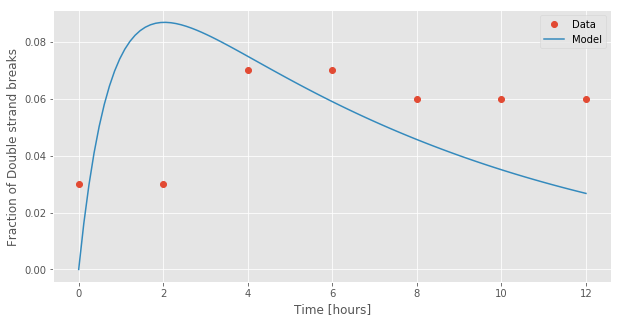

In [108]:
fig,ax = plt.subplots(figsize=(10,5),sharey=False,sharex=True)

df = data_dsb[data_dsb.defect== "NR"]
df = df[df.nuclease == "SpCas9"]
y_data =  df.dsb.values
ax.plot(df.time,y_data/100,'o',label="Data")
trang = np.linspace(times.values[0],times.values[-1],100)
ax.plot(trang,[fit_func(t,np.log(1/2.99),np.log(1/6.86),np.log(1/1)) for t in trang],label="Model")

ax.set_xlabel("Time [hours]")
ax.set_ylabel("Fraction of Double strand breaks")
#ax.set_ylim([0,0.9])
ax.legend()

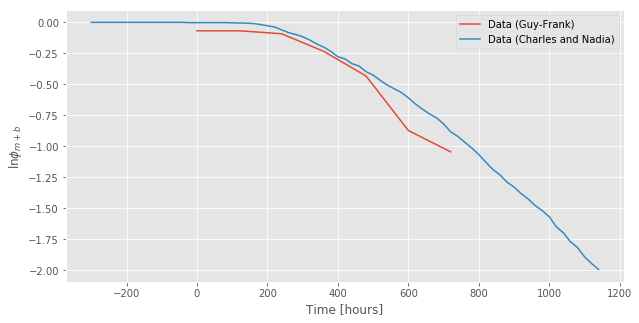

In [264]:
fig,ax = plt.subplots(figsize=(10,5),sharey=False,sharex=True)

m0 = 100-data_dsb[data_dsb.Repeat == "NR"]["DSB (SpCas9)"].values[0]-data_dsb[data_dsb.Repeat == "NR"]["GFP (SpCas9)"].values[0]
y_data = data_dsb[data_dsb.Repeat == "NR"]["DSB (SpCas9)"].values/m0
times = data_dsb[data_dsb.Repeat == "GAA"]["Time (hr)"]

y_data =  data_dsb[data_dsb.Repeat == "NR"]["GFP (SpCas9)"].values/m0
ax.plot(times*60,np.log(1-y_data),'-',label="Data (Guy-Frank)")
# trang = np.linspace(times.values[0],times.values[-1],100)
# ax.plot(trang,[np.log(1-gfp_func(t,np.log(1/2.99),np.log(1/5.86),np.log(1/22))) for t in trang],label="Model")

df = data_avg[data_avg.experiment == 'NR-SpCas9']
ax.plot(df.time-300,np.log(1-df.gfp/df.bf),label="Data (Charles and Nadia)")
ax.set_xlabel("Time [hours]")
ax.set_ylabel(r"$\ln \phi_{m+b}$")
#ax.set_ylim([0,1])
ax.legend()

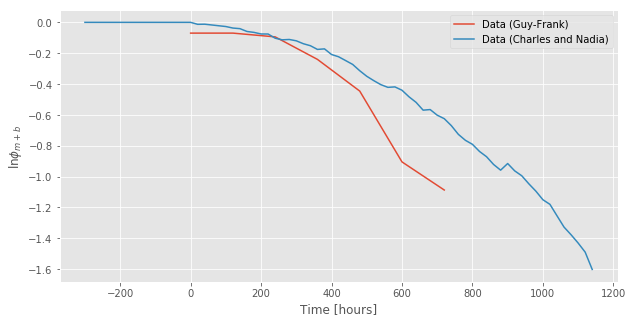

In [266]:
fig,ax = plt.subplots(figsize=(10,5),sharey=False,sharex=True)

m0 = 100-data_dsb[data_dsb.Repeat == "GAA"]["DSB (Cpf1)"].values[0]-data_dsb[data_dsb.Repeat == "NR"]["GFP (SpCas9)"].values[0]
y_data = data_dsb[data_dsb.Repeat == "GAA"]["DSB (Cpf1)"].values/m0
times = data_dsb[data_dsb.Repeat == "GAA"]["Time (hr)"]

y_data =  data_dsb[data_dsb.Repeat == "NR"]["GFP (SpCas9)"].values/m0
ax.plot(times*60,np.log(1-y_data),'-',label="Data (Guy-Frank)")
# trang = np.linspace(times.values[0],times.values[-1],100)
# ax.plot(trang,[np.log(1-gfp_func(t,np.log(1/2.99),np.log(1/5.86),np.log(1/22))) for t in trang],label="Model")

df = data_avg[data_avg.experiment == 'GAA - Cpf1']
ax.plot(df.time-300,np.log(1-df.gfp/df.bf),label="Data (Charles and Nadia)")
ax.set_xlabel("Time [hours]")
ax.set_ylabel(r"$\ln \phi_{m+b}$")
#ax.set_ylim([0,1])
ax.legend()

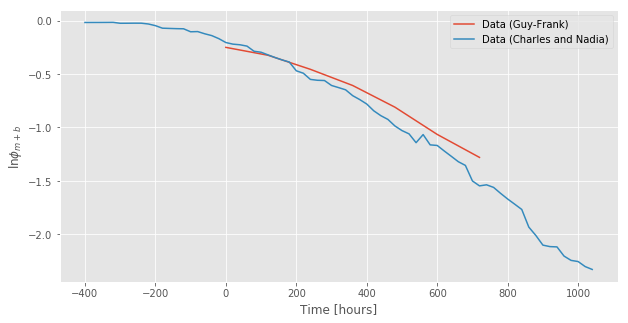

In [268]:
fig,ax = plt.subplots(figsize=(10,5),sharey=False,sharex=True)

m0 = 100-data_dsb[data_dsb.Repeat == "CGG"]["DSB (SpCas9)"].values[0]-data_dsb[data_dsb.Repeat == "NR"]["GFP (SpCas9)"].values[0]
y_data = data_dsb[data_dsb.Repeat == "CGG"]["DSB (SpCas9)"].values/m0
times = data_dsb[data_dsb.Repeat == "GAA"]["Time (hr)"]

y_data =  data_dsb[data_dsb.Repeat == "CGG"]["GFP (SpCas9)"].values/m0
ax.plot(times*60,np.log(1-y_data),'-',label="Data (Guy-Frank)")
# trang = np.linspace(times.values[0],times.values[-1],100)
# ax.plot(trang,[np.log(1-gfp_func(t,np.log(1/2.99),np.log(1/5.86),np.log(1/22))) for t in trang],label="Model")

df = data_avg[data_avg.experiment == 'CGG-SpCas9']
ax.plot(df.time-400,np.log(1-df.gfp/df.bf),label="Data (Charles and Nadia)")
ax.set_xlabel("Time [hours]")
ax.set_ylabel(r"$\ln \phi_{m+b}$")
#ax.set_ylim([0,1])
ax.legend()

In [258]:
data_avg.experiment.unique()

array(['CGG-Cpf1', 'CGG-SpCas9', 'CTG-Cpf1', 'CTG-SpCas9-comb',
       'GAA - Cpf1', 'GAA-SpCas9-comb', 'NR-Cpf1-comb', 'NR-SpCas9',
       'NoGuideRNA'], dtype=object)

4.385964912280701